In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [ ]:
# Carregar o dataset
base_hotel = pd.read_csv('/content/Hotel Reservations.csv')

# Função para classificar o preço
def classify_price(price):
    if price <= 85:
        return 1

    elif price > 85 and price < 115:
        return 2
    else:
        return 3

# Criar a coluna de label 'label_avg_price_per_room'
base_hotel['label_avg_price_per_room'] = base_hotel['avg_price_per_room'].apply(classify_price)
base_hotel = base_hotel.drop(columns=['avg_price_per_room'])

# Reorganizar as colunas
colunas = ['label_avg_price_per_room'] + [col for col in base_hotel.columns if col != 'label_avg_price_per_room']
base_hotel = base_hotel[colunas]

# Lista de colunas a serem removidas
colunas_para_remover = ['Booking_ID', 'arrival_date', 'market_segment_type',
                         'repeated_guest', 'no_of_previous_cancellations',
                         'no_of_previous_bookings_not_canceled', 'booking_status']

# Filtrar e remover as colunas existentes
colunas_existentes = [col for col in colunas_para_remover if col in base_hotel.columns]
base_hotel = base_hotel.drop(columns=colunas_existentes, axis=1).copy()

# Aplicando One-Hot Encoding
base_hotel = pd.get_dummies(base_hotel, prefix=['type_of_meal_plan', 'required_car_parking_space',
                                                'room_type_reserved', 'arrival_year', 'arrival_month',
                                                'no_of_special_requests'],
                             columns=['type_of_meal_plan', 'required_car_parking_space',
                                      'room_type_reserved', 'arrival_year', 'arrival_month',
                                      'no_of_special_requests'])


In [ ]:

# Definindo X e y
X = base_hotel.drop(columns=['label_avg_price_per_room']).values.astype('float32')
y = base_hotel['label_avg_price_per_room'].values

# Codificar os rótulos para começarem de 0
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Normalização das características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir o conjunto de dados em treinamento e teste
X_treinamento, X_teste, Y_treinamento, Y_teste = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=0)

# Configuração dos hiperparâmetros para RandomizedSearchCV
param_distributions = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 6, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'min_child_weight': [1, 2, 3, 4],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [0.5, 1.0, 1.5, 2.0]
}

# Inicializar o classificador XGBoost
model_xgb = xgb.XGBClassifier(
    eval_metric='mlogloss',
    num_class=len(np.unique(y_encoded))
)

# Inicializar o RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model_xgb,
    param_distributions=param_distributions,
    n_iter=50,  # Aumentando o número de combinações para explorar mais opções
    scoring='accuracy',
    cv=5,  # Usar validação cruzada mais rigorosa
    n_jobs=-1,
    verbose=3,
    random_state=0
)

# Treinar o RandomizedSearchCV
random_search.fit(X_treinamento, Y_treinamento)

# Melhor combinação de hiperparâmetros
print("Melhores hiperparâmetros encontrados:\n", random_search.best_params_)

# Melhor modelo encontrado
best_model = random_search.best_estimator_

# Fazer previsões
Y_pred_xgb_encoded = best_model.predict(X_teste)

# Decodificar as previsões de volta para os rótulos originais
Y_pred_xgb = label_encoder.inverse_transform(Y_pred_xgb_encoded)

# Decodificar os rótulos de teste para os rótulos originais
Y_teste_decoded = label_encoder.inverse_transform(Y_teste)

# Avaliar o modelo
print("XGBoost Accuracy Score:", accuracy_score(Y_teste_decoded, Y_pred_xgb))
print("XGBoost Classification Report:\n", classification_report(Y_teste_decoded, Y_pred_xgb))


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Melhores hiperparâmetros encontrados:
 {'subsample': 0.8, 'reg_lambda': 1.0, 'reg_alpha': 0, 'n_estimators': 400, 'min_child_weight': 3, 'max_depth': 15, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.6}
XGBoost Accuracy Score: 0.7904070568776992
XGBoost Classification Report:
               precision    recall  f1-score   support

           1       0.80      0.78      0.79      3258
           2       0.75      0.76      0.76      4006
           3       0.82      0.84      0.83      3619

    accuracy                           0.79     10883
   macro avg       0.79      0.79      0.79     10883
weighted avg       0.79      0.79      0.79     10883



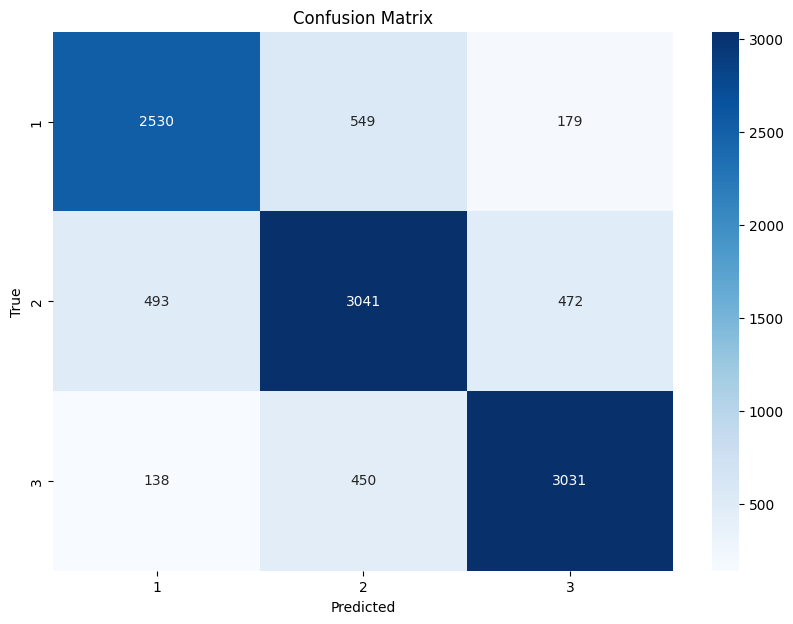

In [ ]:

# Verifique a matriz de confusão
conf_matrix = confusion_matrix(Y_teste_decoded, Y_pred_xgb)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

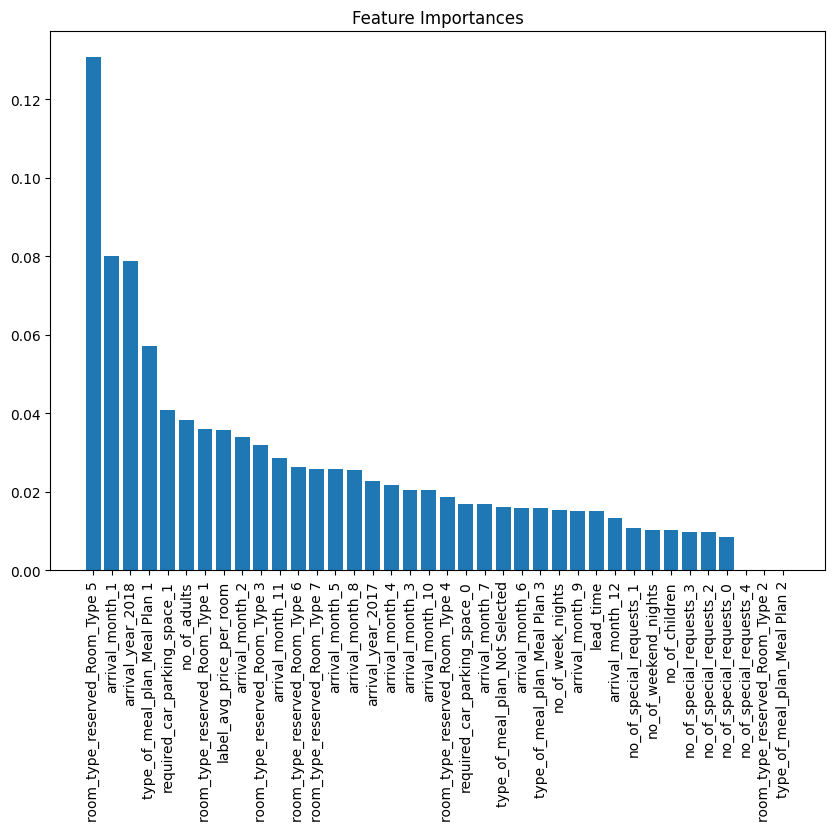

In [ ]:

# Análise da importância das features
feature_importances = best_model.feature_importances_
sorted_idx = np.argsort(feature_importances)[::-1]
plt.figure(figsize=(10, 7))
plt.bar(range(len(feature_importances)), feature_importances[sorted_idx], align='center')
plt.xticks(range(len(feature_importances)), np.array(base_hotel.columns[:-1])[sorted_idx], rotation=90)
plt.title('Feature Importances')
plt.show()

In [ ]:
# Cross-validation para avaliação adicional
cv_scores = cross_val_score(best_model, X_scaled, y_encoded, cv=5, scoring='accuracy')
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean Cross-Validation Accuracy:", cv_scores.mean())

Cross-Validation Accuracy Scores: [0.7911785  0.80234321 0.79269469 0.79228119 0.78883529]
Mean Cross-Validation Accuracy: 0.7934665747760166
